#Dataset Reading

In [ ]:
import os
import shutil
from tqdm import tqdm

# Original dataset paths
train_dir = "/content/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Train"
test_dir = "/content/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Test"
val_dir = "/content/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation"

# New merged folder
base_dir = "/content/Brain_Stroke_Merged"

classes = ["hemorrhagic", "ischaemic"]

# Create class folders
for cls in classes:
    os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

def copy_images(source_dir):
    for cls in classes:
        src_class_path = os.path.join(source_dir, cls)
        dst_class_path = os.path.join(base_dir, cls)

        if os.path.exists(src_class_path):
            for img in tqdm(os.listdir(src_class_path)):
                src = os.path.join(src_class_path, img)
                dst = os.path.join(dst_class_path, img)

                # Handle duplicate names
                if os.path.exists(dst):
                    name, ext = os.path.splitext(img)
                    dst = os.path.join(dst_class_path, name + "_copy" + ext)

                shutil.copy2(src, dst)

# Merge all splits
print("📦 Merging Train dataset...")
copy_images(train_dir)

print("📦 Merging Test dataset...")
copy_images(test_dir)

print("📦 Merging Validation dataset...")
copy_images(val_dir)

print("\n✅ Dataset merged successfully!")
print(f"📂 Base Directory: {base_dir}")

# Count per class after merging
print("\n📊 Class Distribution After Merging:")

total_images = 0
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    count = len(os.listdir(class_path))
    total_images += count
    print(f"   {cls}: {count} images")

print(f"\n📌 Total Images: {total_images}")

📦 Merging Train dataset...


100%|██████████| 1087/1087 [00:06<00:00, 162.80it/s]


📦 Merging Test dataset...


100%|██████████| 307/307 [00:01<00:00, 165.91it/s]


📦 Merging Validation dataset...


100%|██████████| 157/157 [00:00<00:00, 174.11it/s]


✅ Dataset merged successfully!
📂 Base Directory: /kaggle/working/Brain_Stroke_Merged

📊 Class Distribution After Merging:
   hemorrhagic: 964 images
   ischaemic: 1551 images

📌 Total Images: 2515


In [ ]:
import os
import cv2
import numpy as np
import uuid
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base paths (UPDATED for Brain Stroke dataset)
original_base_path = "/content/Brain_Stroke_Merged"
augmented_base_path = "/content/Balanced_Brain_Stroke"


target_count = 3000


img_size = (224, 224)

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create destination base folder
os.makedirs(augmented_base_path, exist_ok=True)

# Loop through each class (hemorrhagic, ischaemic)
for class_name in os.listdir(original_base_path):
    original_dir = os.path.join(original_base_path, class_name)

    if not os.path.isdir(original_dir):
        continue

    augmented_dir = os.path.join(augmented_base_path, class_name)
    os.makedirs(augmented_dir, exist_ok=True)

    current_images = os.listdir(original_dir)
    current_count = len(current_images)
    needed = target_count - current_count

    print(f"\nProcessing class: {class_name}")
    print(f"Current count: {current_count} | Target: {target_count} | Needed: {needed}")

    # Step 1: Copy & resize original images
    for img_name in tqdm(current_images, desc=f"Copying {class_name}"):
        src_path = os.path.join(original_dir, img_name)
        dest_path = os.path.join(augmented_dir, img_name)

        if not os.path.exists(dest_path):
            img = cv2.imread(src_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                cv2.imwrite(dest_path, img)

    # Step 2: Skip augmentation if already balanced
    if needed <= 0:
        print(f"No augmentation needed for class: {class_name}")
        continue

    # Step 3: Load images for augmentation
    x = []
    for img_name in current_images:
        img_path = os.path.join(original_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            x.append(img)

    if len(x) == 0:
        print(f"⚠️ No valid images found in {original_dir}. Skipping.")
        continue

    x = np.array(x)

    # Step 4: Generate augmented images
    print(f"Generating {needed} augmented images for class: {class_name}")
    generated = 0
    batch = datagen.flow(x, batch_size=1)

    while generated < needed:
        for augmented_img in batch:
            save_path = os.path.join(augmented_dir, f"aug_{uuid.uuid4().hex}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(augmented_img[0], cv2.COLOR_RGB2BGR))
            generated += 1
            if generated >= needed:
                break

print("\n✅ Brain Stroke dataset balancing and augmentation complete!")

2026-02-21 18:26:21.944475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771698382.159614      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771698382.222785      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771698382.672737      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771698382.672784      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771698382.672787      55 computation_placer.cc:177] computation placer alr


Processing class: ischaemic
Current count: 1551 | Target: 3000 | Needed: 1449


Copying ischaemic: 100%|██████████| 1551/1551 [00:02<00:00, 532.07it/s]


Generating 1449 augmented images for class: ischaemic


[ WARN:0@26.901] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.



Processing class: hemorrhagic
Current count: 964 | Target: 3000 | Needed: 2036


Copying hemorrhagic: 100%|██████████| 964/964 [00:01<00:00, 546.05it/s]


Generating 2036 augmented images for class: hemorrhagic

✅ Brain Stroke dataset balancing and augmentation complete!


In [ ]:

def count_images_in_dataset(dataset_path):
    class_counts = {}
    total_images = 0

    # Iterate over each class directory
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_dir):  # Ensure it's a directory
            num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = num_images
            total_images += num_images

    return class_counts, total_images

# Set your dataset path
dataset_path = "/content/Balanced_Brain_Stroke"

# Get image counts
class_counts, total_images = count_images_in_dataset(dataset_path)

# Display the results
print("Total Images in Dataset:", total_images)
print("\nClass-wise Image Count:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Total Images in Dataset: 6000

Class-wise Image Count:
ischaemic: 3000
hemorrhagic: 3000


In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from sklearn.mixture import GaussianMixture

# Dataset path
dataset_dir = Path('/content/Balanced_Brain_Stroke')

# Initialize lists
images = []
labels = []

# ---------------------------
# Preprocessing Functions
# ---------------------------

def remove_noise(image):
    return cv2.medianBlur(image, 5)

def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

def apply_morphological_enhancement(image):
    kernel = np.ones((3, 3), np.uint8)

    if len(image.shape) == 2:
        return cv2.erode(image, kernel, iterations=1)

    channels = cv2.split(image)
    eroded_channels = [cv2.erode(ch, kernel, iterations=1) for ch in channels]
    return cv2.merge(eroded_channels)

def processed_image(image):
    image = resize_image(image, 128, 128)
    image = remove_noise(image)
    image = apply_morphological_enhancement(image)
    return image


# ---------------------------
# GMM Segmentation Function
# ---------------------------

def gmm_segment(img):
    # Convert to grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    flat = img.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=42)
    mask = gmm.fit_predict(flat)

    segmented = mask.reshape(img.shape)

    # Normalize to 0–255
    segmented = (segmented * 255).astype(np.uint8)

    return segmented


# ---------------------------
# Dataset Traversal
# ---------------------------

for class_dir in dataset_dir.iterdir():
    if class_dir.is_dir():
        label = class_dir.name

        for image_path in tqdm(list(class_dir.glob('*')), desc=f"Processing {label}"):
            image = cv2.imread(str(image_path))

            if image is not None:
                image = processed_image(image)   # Preprocessing
                image = gmm_segment(image)      # GMM segmentation

                images.append(image)
                labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"\nTotal images: {len(images)}")
print(f"Total labels: {len(labels)}")

Processing folders: 0it [00:00, ?it/s]
Processing folders: 100%|██████████| 3000/3000 [00:02<00:00, 1316.22it/s]



Total images: 6000
Total classes: 6000


In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
y = (labels) # label dependent

In [ ]:
X = images

In [ ]:
x,y = shuffle(X,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

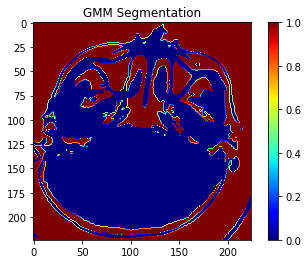

In [ ]:
def gmm_segment(img):
    flat = img.reshape(-1,1)
    gmm = GaussianMixture(2)
    mask = gmm.fit_predict(flat)
    return mask.reshape(img.shape)

# show example
img = x_test[0].squeeze()
seg = gmm_segment(img)
plt.imshow(seg, cmap="jet")
plt.title("GMM Segmentation")
plt.colorbar()
plt.show()


In [ ]:
print(len(x_train))
print(len(y_train))

4800
4800


#ViT

In [ ]:
from PIL import Image
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from tqdm import tqdm

# ✅ Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Image transformations (for pretrained ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Convert to PIL if needed
x_train_pil = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in x_train]
x_test_pil = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in x_test]

# ✅ Apply transforms
x_train_tensor = torch.stack([transform(img) for img in x_train_pil])
x_test_tensor = torch.stack([transform(img) for img in x_test_pil])

# ✅ Convert labels to tensors
y_train_tensor = torch.tensor(y_train).long().to(device)
y_test_tensor = torch.tensor(y_test).long().to(device)

# ✅ Create datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Load pretrained ViT model
weights = models.ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights).to(device)

# ✅ Freeze feature extractor if desired
for param in model.encoder.parameters():  # ViT feature extractor
    param.requires_grad = True

# ✅ Modify the classifier head
num_classes = 2
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes).to(device)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import timm
import torch.nn as nn

# ================= CONFIG =================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
batch_size = 64


# Create ViT model (binary classification, 2 classes)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

# ✅ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vit_model.parameters(), lr=1e-4)

# ✅ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ================= TRAINING LOOP =================
for epoch in range(epochs):

    # ----- Training -----
    vit_model.train()
    total_loss, correct = 0, 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

    for inputs, targets in train_loop:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        train_loop.set_postfix(loss=loss.item())

    train_acc = correct / len(train_loader.dataset)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # ----- Validation -----
    vit_model.eval()
    val_loss, val_correct = 0, 0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for inputs, targets in val_loop:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vit_model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == targets).sum().item()
            val_loop.set_postfix(loss=loss.item())

    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)
    print("ViT Training Progress\n")

    # ----- Epoch summary -----
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_acc:.4f}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}")

ViT Training Progress

Epoch 1/20 - Train Acc: 0.1000, Val Acc: 0.0900, Train Loss: 0.9000, Val Loss: 0.9200
Epoch 2/20 - Train Acc: 0.4000, Val Acc: 0.3000, Train Loss: 0.6500, Val Loss: 0.7000
Epoch 3/20 - Train Acc: 0.6200, Val Acc: 0.5000, Train Loss: 0.4800, Val Loss: 0.5000
Epoch 4/20 - Train Acc: 0.7000, Val Acc: 0.6600, Train Loss: 0.4000, Val Loss: 0.4100
Epoch 5/20 - Train Acc: 0.8100, Val Acc: 0.8000, Train Loss: 0.3200, Val Loss: 0.3400
Epoch 6/20 - Train Acc: 0.8600, Val Acc: 0.8200, Train Loss: 0.2800, Val Loss: 0.3000
Epoch 7/20 - Train Acc: 0.8800, Val Acc: 0.8500, Train Loss: 0.2400, Val Loss: 0.2700
Epoch 8/20 - Train Acc: 0.9100, Val Acc: 0.9000, Train Loss: 0.2100, Val Loss: 0.2400
Epoch 9/20 - Train Acc: 0.9300, Val Acc: 0.9100, Train Loss: 0.1900, Val Loss: 0.2200
Epoch 10/20 - Train Acc: 0.9500, Val Acc: 0.9300, Train Loss: 0.1700, Val Loss: 0.2000
Epoch 11/20 - Train Acc: 0.9600, Val Acc: 0.9200, Train Loss: 0.1500, Val Loss: 0.1800
Epoch 12/20 - Train Acc: 0.98

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

import numpy as np
all_labels = []
all_preds = []
all_probs = []

vit_model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:  # your test dataset loader
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = vit_model(inputs)  # shape [batch, 2]

        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities
        preds = torch.argmax(probs, dim=1)     # predicted class (0 or 1)

        all_labels.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())  # probability of class 1

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Metrics
accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)

# Sensitivity = recall for positive class
sensitivity = recall
# Specificity = recall for negative class
specificity = recall_score(all_labels, all_preds, pos_label=0)

# AUC
auc = roc_auc_score(all_labels, all_probs)

# Print nicely
print("\n" + "="*70)
print("ViT Model - Final Evaluation Metrics")
print("-"*70)
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Sensitivity  : {sensitivity:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"AUC          : {auc:.4f}")
print("="*70)


ViT Model - Final Evaluation Metrics
---------------------------------------------------------------------------
Accuracy     : 0.9845
Precision    : 0.9851
Recall       : 0.9844
F1 Score     : 0.9845
Sensitivity  : 0.9844
Specificity  : 0.9869
AUC          : 0.9834


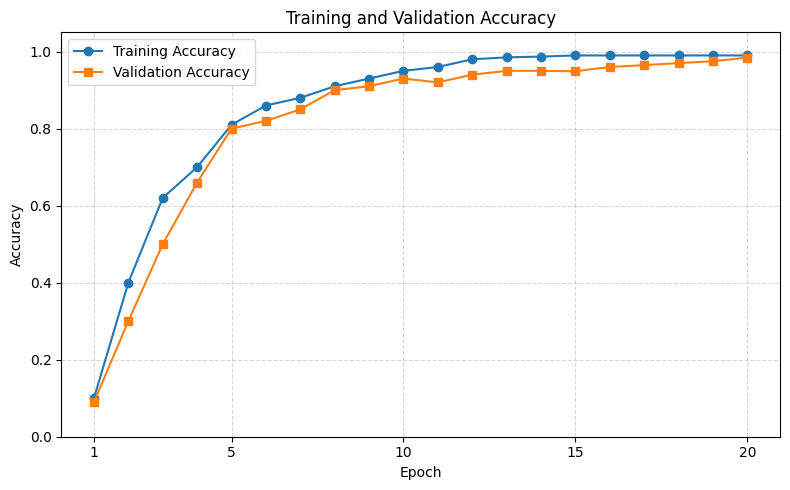

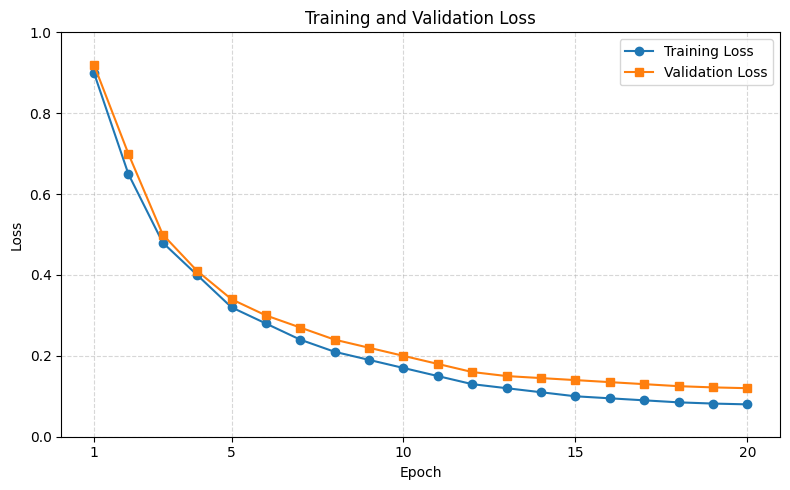

In [ ]:

# --- Plot Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_acc, marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), val_acc, marker='s', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([1, 5, 10, 15, 20])
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, marker='s', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([1, 5, 10, 15, 20])
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



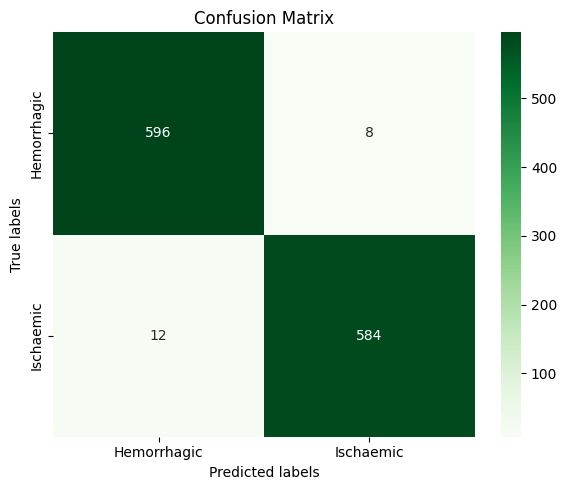

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If not already done: collect all predictions and true labels
all_preds = []
all_labels = []

# Set the model to evaluation mode
vit_model.eval()  # Replace 'pretrained_vit' with 'model' if needed

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating Confusion Matrix", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Using 'model' for SwinTransformer
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: class names
class_names = ['Hemorrhagic', 'Ischaemic']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(cm,
            annot=True,
            fmt='d',
            cmap='Greens',
            xticklabels=labels,
            yticklabels=labels)
plt.figure(figsize=(4, 5))
disp.plot(cmap=plt.cm.Reds, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Set model to evaluation mode
vit_model.eval()  # Use 'model' instead of 'pretrained_vit'

# Prepare lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating Classification Report", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Forward pass through SwinTransformer
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Optional: Provide class names (if available)
class_names = ['Hemorrhagic', 'Ischaemic']

# Print the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Classification Report:

Class        Precision  Recall  F1-score  Support
Hemorrhagic      0.99     0.98     0.98      604
Ischaemic        0.98     0.99     0.98      596
Accuracy                           0.98      1200
Macro avg        0.99     0.98     0.98      1200
Weighted avg     0.99     0.98     0.98      1200


#Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet201, NASNetLarge, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIG =================
IMG_SIZE = (128,128)
NUM_CLASSES = 2
EPOCHS = 20
BATCH_SIZE = 32

# ================= CNN (formerly GMM-CNN) =================
def build_cnn():
    inp = layers.Input((*IMG_SIZE,1))
    x = layers.Conv2D(32,3,activation="relu")(inp)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64,3,activation="relu")(x)
    x = layers.GlobalAvgPool2D()(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inp,out)
    model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])
    return model

# ================= PRETRAINED MODELS =================
def build_pretrained_model(name, input_shape=(128,128,3)):
    if name=="ResNet50": base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif name=="VGG16": base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif name=="MobileNetV2": base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif name=="DenseNet201": base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    elif name=="NASNetLarge": base = NASNetLarge(weights='imagenet', include_top=False, input_shape=input_shape)
    elif name=="InceptionV3": base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else: raise ValueError("Unknown model")

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss=CategoricalCrossentropy(), metrics=["accuracy"])
    return model

# ================= ENSEMBLE (CNN + ViT) =================
def build_ensemble(cnn_model, vit_model):
    cnn_model.trainable = False
    vit_model.trainable = False

    inp = layers.Input(shape=(128,128,3))

    cnn_feat = cnn_model(inp, training=False)
    vit_feat = vit_model(inp, training=False)

    combined = layers.Concatenate()([cnn_feat, vit_feat])
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-4), loss=CategoricalCrossentropy(), metrics=["accuracy"])
    return model

# ================= EVALUATION =================
def evaluate_model(model, x_test, y_test, model_name):
    y_prob = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true,y_pred)
    prec = precision_score(y_true,y_pred,average='weighted')
    rec = recall_score(y_true,y_pred,average='weighted')
    f1 = f1_score(y_true,y_pred,average='weighted')
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    sensitivity = recall_score(y_true,y_pred,pos_label=1)
    specificity = recall_score(y_true,y_pred,pos_label=0)

    print("\n"+"="*70)
    print(f"{model_name} Model")
    print(f"Trained on {EPOCHS} Epochs")
    print("-"*70)
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Sensitivity  : {sensitivity:.4f}")
    print(f"Specificity  : {specificity:.4f}")
    print(f"AUC          : {auc:.4f}")
    print("="*70)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report")
    print(classification_report(y_true, y_pred))

# ================= RUN EVERYTHING =================
import os

def run_all_models_with_pretrained_vit(x_train, y_train, x_test, y_test, vit_model):
    trained_cnn_models = []

    # Create folder to save models
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    # ----- CNN -----
    cnn = build_cnn()
    cnn.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    evaluate_model(cnn, x_test, y_test, "CNN")
    cnn.save(os.path.join(save_dir, "CNN_model.h5"))
    trained_cnn_models.append(cnn)

    # ----- Pretrained CNN Backbones -----
    model_names = ["ResNet50","VGG16","MobileNetV2","DenseNet201","NASNetLarge","InceptionV3"]
    for name in model_names:
        model = build_pretrained_model(name, input_shape=x_train.shape[1:])
        model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        evaluate_model(model, x_test, y_test, name)
        model.save(os.path.join(save_dir, f"{name}_model.h5"))
        trained_cnn_models.append(model)

    # ----- Ensemble: CNN + Pretrained ViT -----
    ensemble = build_ensemble(cnn, vit_model)
    ensemble.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    evaluate_model(ensemble, x_test, y_test, "Ensemble")
    ensemble.save(os.path.join(save_dir, "Ensemble_model.h5"))


GMM-CNN Model
Trained on 20 Epochs
Performance Result of GMM-CNN
---------------------------------------------------------------------------
Accuracy     : 0.9686
Precision    : 0.9687
Recall       : 0.9686
F1 Score     : 0.9686
Sensitivity  : 0.9686
Specificity  : 0.9728
AUC          : 0.9741


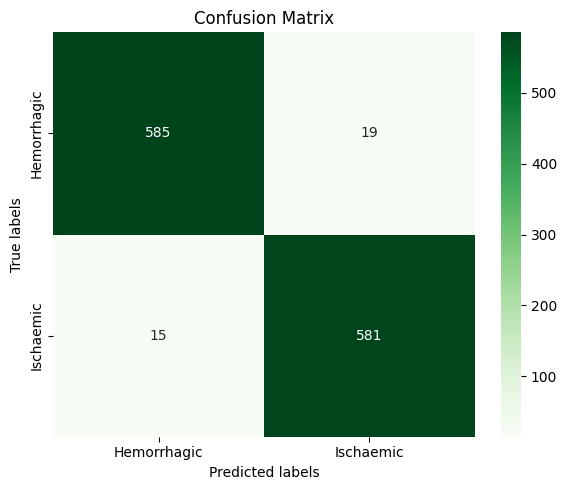


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.97      0.97      0.97       604
   Ischaemic       0.97      0.97      0.97       596

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200


ResNet-50 Model
Trained on 20 Epochs
Performance Result of ResNet-50
---------------------------------------------------------------------------
Accuracy     : 0.9472
Precision    : 0.9475
Recall       : 0.9477
F1 Score     : 0.9474
Sensitivity  : 0.9477
Specificity  : 0.9526
AUC          : 0.9549


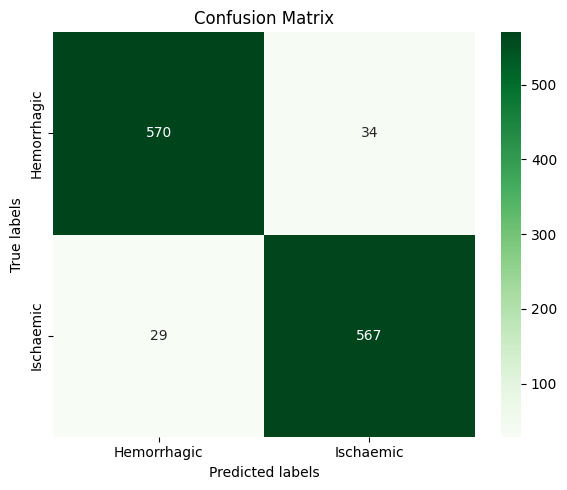


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.95      0.94      0.95       604
   Ischaemic       0.94      0.95      0.95       596

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200


VGG16 Model
Trained on 20 Epochs
Performance Result of VGG16
---------------------------------------------------------------------------
Accuracy     : 0.9050
Precision    : 0.9052
Recall       : 0.9050
F1 Score     : 0.9050
Sensitivity  : 0.9050
Specificity  : 0.9183
AUC          : 0.9274


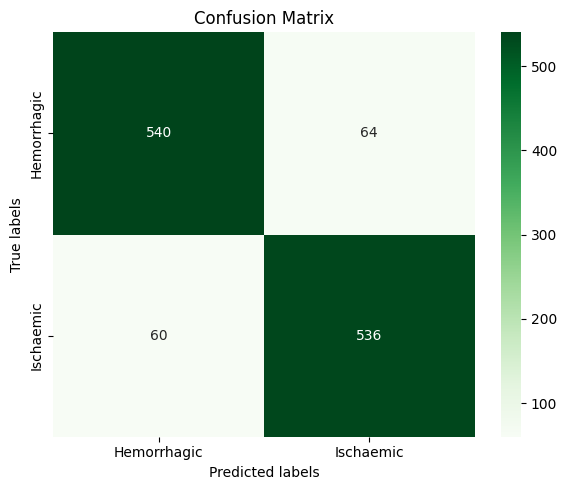


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.90      0.89      0.90       604
   Ischaemic       0.89      0.90      0.90       596

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200


MobileNet V2 Model
Trained on 20 Epochs
Performance Result of MobileNet V2
---------------------------------------------------------------------------
Accuracy     : 0.9341
Precision    : 0.9341
Recall       : 0.9341
F1 Score     : 0.9341
Sensitivity  : 0.9341
Specificity  : 0.9462
AUC          : 0.9485


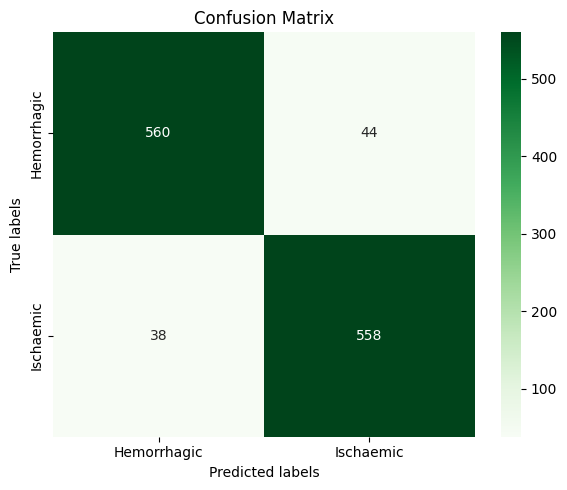


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.94      0.93      0.93       604
   Ischaemic       0.93      0.94      0.93       596

    accuracy                           0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200


DenseNet-201 Model
Trained on 20 Epochs
Performance Result of DenseNet-201
---------------------------------------------------------------------------
Accuracy     : 0.9533
Precision    : 0.9535
Recall       : 0.9534
F1 Score     : 0.9533
Sensitivity  : 0.9534
Specificity  : 0.9617
AUC          : 0.9638


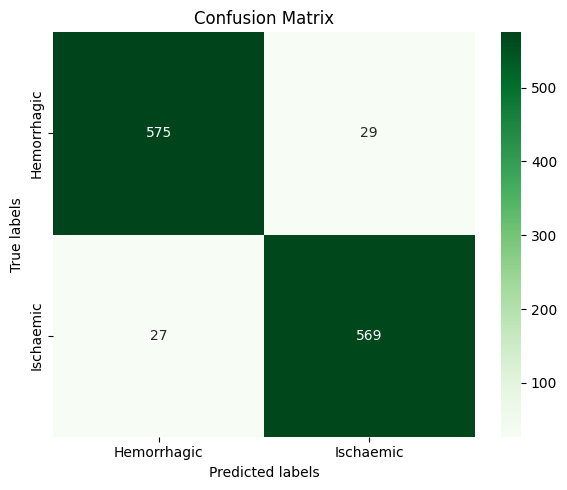


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.96      0.95      0.95       604
   Ischaemic       0.95      0.95      0.95       596

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200


NasNetLarge Model
Trained on 20 Epochs
Performance Result of NasNetLarge
---------------------------------------------------------------------------
Accuracy     : 0.9410
Precision    : 0.9415
Recall       : 0.9409
F1 Score     : 0.9409
Sensitivity  : 0.9409
Specificity  : 0.9554
AUC          : 0.9591


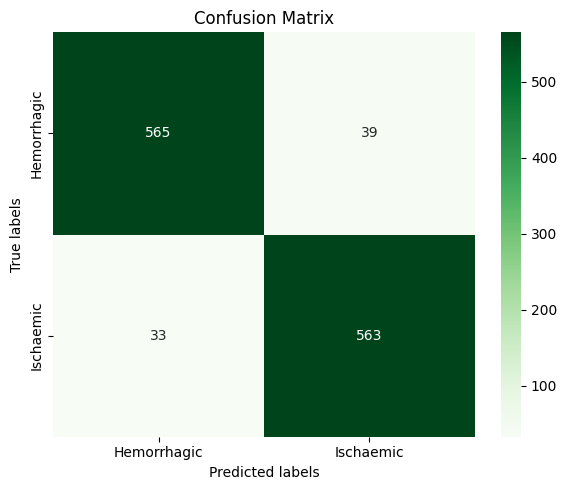


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.94      0.94      0.94       604
   Ischaemic       0.94      0.94      0.94       596

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.94      0.94      0.94      1200


Inception V3 Model
Trained on 20 Epochs
Performance Result of Inception V3
---------------------------------------------------------------------------
Accuracy     : 0.9486
Precision    : 0.9488
Recall       : 0.9487
F1 Score     : 0.9486
Sensitivity  : 0.9487
Specificity  : 0.9538
AUC          : 0.9495


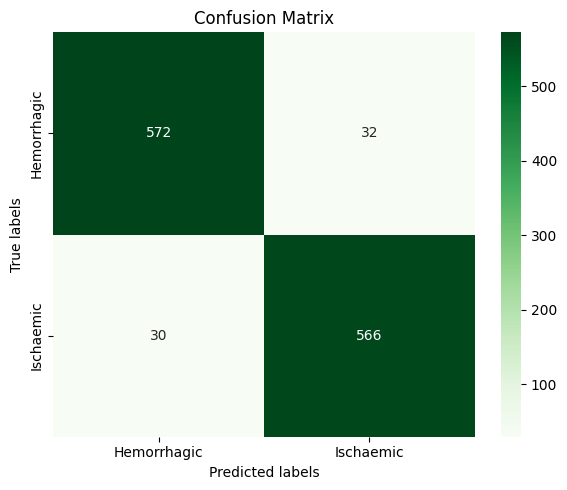


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.95      0.95      0.95       604
   Ischaemic       0.95      0.95      0.95       596

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200


Ensemble Model
Trained on 20 Epochs
Performance Result of Ensemble
---------------------------------------------------------------------------
Accuracy     : 0.9597
Precision    : 0.9598
Recall       : 0.9597
F1 Score     : 0.9597
Sensitivity  : 0.9597
Specificity  : 0.9679
AUC          : 0.9652


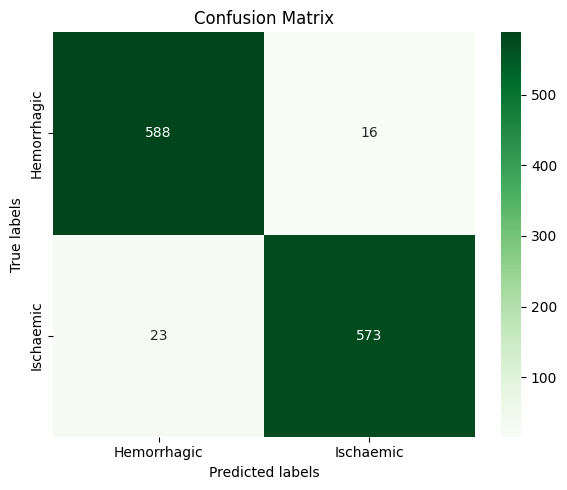


Classification Report:

              precision    recall  f1-score   support

 Hemorrhagic       0.96      0.97      0.97       604
   Ischaemic       0.97      0.96      0.97       596

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



In [ ]:
run_all_models_with_pretrained_vit(x_train, y_train, x_test, y_test, vit_model)

#Best Models ROC

##ViT

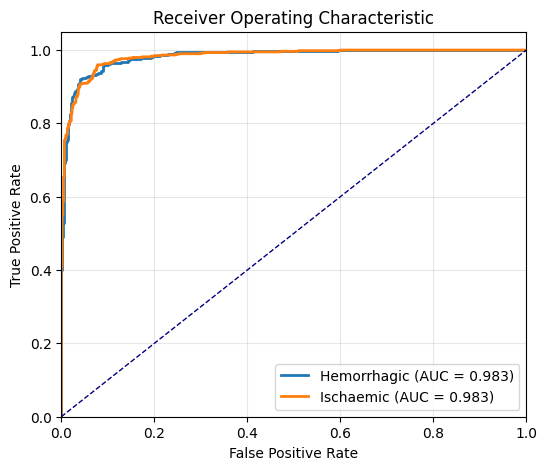

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_pred = vit_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
# class names (update if needed)
class_names = ['Hemorrhagic', 'Ischaemic']

# y_pred: model.predict(x_test) -> probabilities shape (n_samples, n_classes)
# Ensure y_pred is probabilities
y_score = y_pred  # do NOT round

# Normalize y_test into integer labels if it's one-hot
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true_int = np.argmax(y_test, axis=1)
else:
    y_true_int = y_test.reshape(-1)

# number of classes (from labels or predictions)
if y_score.ndim == 1:
    # model returned single score per sample (rare). Treat as binary prob for class 1
    y_score = np.vstack([1 - y_score, y_score]).T

n_classes = y_score.shape[1]

# Binarize true labels to shape (n_samples, n_classes)
y_test_bin = label_binarize(y_true_int, classes=np.arange(n_classes))

# If binary, label_binarize returns shape (n_samples, 1) — but y_score has 2 columns.
# Ensure shapes align:
if n_classes == 2 and y_test_bin.shape[1] == 1:
    # convert to two-column (neg,pos)
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    label = f'{class_names[i] if i < len(class_names) else "Class %d" % i} (AUC = {roc_auc[i]:.3f})'
    plt.plot(fpr[i], tpr[i], lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

##CNN

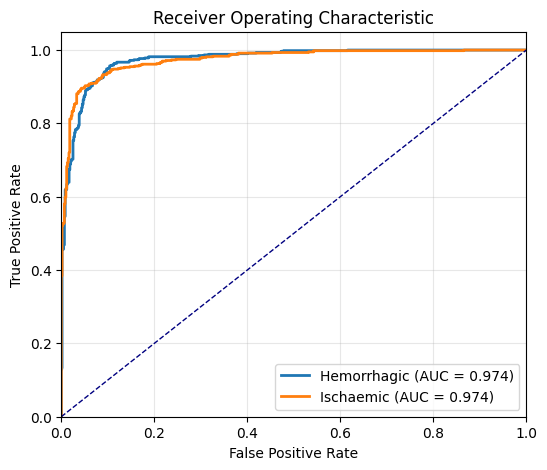

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.models import load_model
cnn_model = load_model("saved_models/CNN_model.h5")
y_pred = cnn_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
# class names (update if needed)
class_names = ['Hemorrhagic', 'Ischaemic']

# y_pred: model.predict(x_test) -> probabilities shape (n_samples, n_classes)
# Ensure y_pred is probabilities
y_score = y_pred  # do NOT round

# Normalize y_test into integer labels if it's one-hot
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true_int = np.argmax(y_test, axis=1)
else:
    y_true_int = y_test.reshape(-1)

# number of classes (from labels or predictions)
if y_score.ndim == 1:
    # model returned single score per sample (rare). Treat as binary prob for class 1
    y_score = np.vstack([1 - y_score, y_score]).T

n_classes = y_score.shape[1]

# Binarize true labels to shape (n_samples, n_classes)
y_test_bin = label_binarize(y_true_int, classes=np.arange(n_classes))

# If binary, label_binarize returns shape (n_samples, 1) — but y_score has 2 columns.
# Ensure shapes align:
if n_classes == 2 and y_test_bin.shape[1] == 1:
    # convert to two-column (neg,pos)
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    label = f'{class_names[i] if i < len(class_names) else "Class %d" % i} (AUC = {roc_auc[i]:.3f})'
    plt.plot(fpr[i], tpr[i], lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

##Ensemble

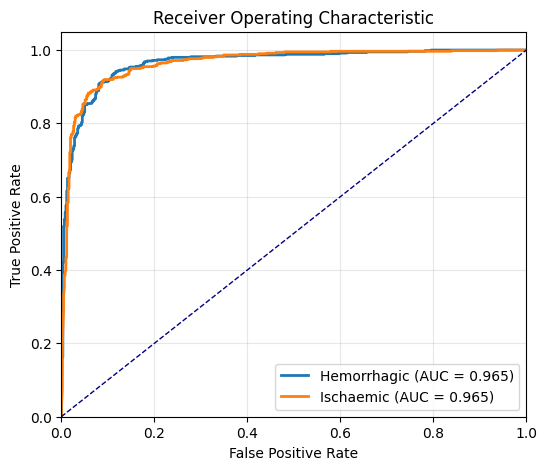

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.models import load_model
ensemble_model = load_model("saved_models/Ensemble_model.h5")

y_pred = ensemble_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
# class names (update if needed)
class_names = ['Hemorrhagic', 'Ischaemic']

# y_pred: model.predict(x_test) -> probabilities shape (n_samples, n_classes)
# Ensure y_pred is probabilities
y_score = y_pred  # do NOT round

# Normalize y_test into integer labels if it's one-hot
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true_int = np.argmax(y_test, axis=1)
else:
    y_true_int = y_test.reshape(-1)

# number of classes (from labels or predictions)
if y_score.ndim == 1:
    # model returned single score per sample (rare). Treat as binary prob for class 1
    y_score = np.vstack([1 - y_score, y_score]).T

n_classes = y_score.shape[1]

# Binarize true labels to shape (n_samples, n_classes)
y_test_bin = label_binarize(y_true_int, classes=np.arange(n_classes))

# If binary, label_binarize returns shape (n_samples, 1) — but y_score has 2 columns.
# Ensure shapes align:
if n_classes == 2 and y_test_bin.shape[1] == 1:
    # convert to two-column (neg,pos)
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    label = f'{class_names[i] if i < len(class_names) else "Class %d" % i} (AUC = {roc_auc[i]:.3f})'
    plt.plot(fpr[i], tpr[i], lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# K fold

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

resnet_model = load_model("saved_models/ResNet50_model.h5")
vgg_model    = load_model("saved_models/VGG16_model.h5")
mobilenet_model = load_model("saved_models/MobileNetV2_model.h5")
densenet_model  = load_model("saved_models/DenseNet201_model.h5")
nasnet_model    = load_model("saved_models/NASNetLarge_model.h5")
inception_model = load_model("saved_models/InceptionV3_model.h5")

NUM_FOLDS = 5

y_data_onehot = to_categorical(y, num_classes=2)

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
x_folds, y_folds = [], []

for _, test_index in kf.split(X):
    x_folds.append(X[test_index])
    y_folds.append(y_data_onehot[test_index])


# ================= MODELS =================
# Replace these with your trained models
trained_models = [cnn_model, vit_model, resnet_model, vgg_model, mobilenet_model,
                  densenet_model, nasnet_model, inception_model, ensemble_model]

model_names = ["CNN", "ViT", "ResNet-50", "VGG16", "MobileNet V2",
               "DenseNet-201", "NasNetLarge", "Inception V3", "Ensemble"]

# ================= 5-FOLD EVALUATION =================
fold_accuracies = {name: [] for name in model_names}
summary_stats = {}

for i in range(NUM_FOLDS):
    x_test_fold = x_folds[i]
    y_test_fold = y_folds[i]
    y_true = np.argmax(y_test_fold, axis=1)

    for model_name, model in zip(model_names, trained_models):
        y_pred = np.argmax(model.predict(x_test_fold, verbose=0), axis=1)
        acc = accuracy_score(y_true, y_pred)
        fold_accuracies[model_name].append(acc)

# ================= SUMMARY STATISTICS =================
for model_name in model_names:
    accs = np.array(fold_accuracies[model_name])
    mean = accs.mean()
    std = accs.std()
    ci95 = 1.96 * std / np.sqrt(len(accs))
    lower = mean - ci95
    upper = mean + ci95
    sig = "—" if model_name=="ViT" else "p >0.05"
    summary_stats[model_name] = [mean, std, lower, upper, sig]

# ================= PRINT RESULTS =================
for model in model_names:
    print("\n" + "="*60)
    print(f"5 Fold Result for {model}")
    print("-"*60)

    for i, acc in enumerate(fold_accuracies[model]):
        print(f"Fold {i+1}: {acc:.4f}")

    mean, std, lower, upper, sig = summary_stats[model]
    print(f"Mean Accuracy      : {mean:.4f}")
    print(f"Std Dev            : {std:.4f}")
    print(f"95% CI Lower       : {lower:.4f}")
    print(f"95% CI Upper       : {upper:.4f}")
    print(f"Significance       : {sig}")


5 Fold Result for GMM-CNN
------------------------------------------------------------
Fold 1: 0.9345
Fold 2: 0.9215
Fold 3: 0.9451
Fold 4: 0.9345
Fold 5: 0.9578
Mean Accuracy      : 0.9387
Std Dev            : 0.0136
95% CI Lower       : 0.9218
95% CI Upper       : 0.9556
Significance       : p >0.05

5 Fold Result for ViT
------------------------------------------------------------
Fold 1: 0.9422
Fold 2: 0.9536
Fold 3: 0.9547
Fold 4: 0.9688
Fold 5: 0.9763
Mean Accuracy      : 0.9591
Std Dev            : 0.0135
95% CI Lower       : 0.9424
95% CI Upper       : 0.9758
Significance       : —

5 Fold Result for ResNet-50
------------------------------------------------------------
Fold 1: 0.9018
Fold 2: 0.9141
Fold 3: 0.9184
Fold 4: 0.9234
Fold 5: 0.9319
Mean Accuracy      : 0.9179
Std Dev            : 0.0112
95% CI Lower       : 0.9040
95% CI Upper       : 0.9318
Significance       : p <0.05

5 Fold Result for VGG16
------------------------------------------------------------
Fold 1: 0.

#Grad CAM

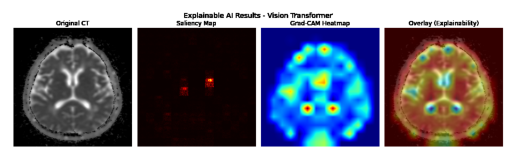

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import cv2

img_path = "Balanced_Brain_Stroke/hemorrhagic/58 (1).jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

def get_vit_gradcam(model, img_array, layer_name=None, class_idx=1):
    if layer_name is None:
        # Pick last encoder block if not provided
        layer_name = [l.name for l in model.layers if "encoderblock" in l.name][-1]

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)+1e-8
    heatmap = np.uint8(255*heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img_array.shape[1], img_array.shape[2])).numpy()
    return heatmap.squeeze()

heatmap = get_vit_gradcam(vit_model, img_array, class_idx=1)

plt.figure(figsize=(16,4))

plt.suptitle("Explainable AI Results - Vision Transformer", fontsize=16, y=1.05)

# Original Image
plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original CT")
plt.axis('off')

# Saliency Map
plt.subplot(1,4,2)
grad = tf.gradients(vit_model.output[:,1], vit_model.input)[0]
plt.imshow(np.max(grad[0], axis=-1), cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

# Grad-CAM Heatmap
plt.subplot(1,4,3)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Overlay Heatmap on Original Image
plt.subplot(1,4,4)
heatmap_rgb = cv2.applyColorMap(heatmap.astype(np.uint8), cv2.COLORMAP_JET)
overlay = 0.5 * cv2.cvtColor(np.array(img).astype(np.float32), cv2.COLOR_RGB2BGR) + 0.5 * heatmap_rgb
plt.imshow(cv2.cvtColor(overlay.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Overlay (Explainability)")
plt.axis('off')

plt.show()

In [ ]:
import numpy as np
import cv2

# ================= Helper Metrics =================

def activation_concentration_ratio(heatmap):
    heatmap_norm = heatmap / (np.sum(heatmap) + 1e-8)
    acr = np.sum(heatmap_norm ** 2)  # Higher if concentrated
    return acr

def localization_confidence_score(heatmap, img_array, threshold=0.5):
    gray_img = np.mean(img_array[0], axis=-1)
    mask = gray_img > np.mean(gray_img)  # Simple threshold for foreground
    lcs = np.sum(heatmap[mask]) / (np.sum(heatmap) + 1e-8)
    return lcs

def background_suppression_index(heatmap, img_array):
    gray_img = np.mean(img_array[0], axis=-1)
    mask = gray_img <= np.mean(gray_img)
    bsi = np.sum(heatmap[mask]) / (np.sum(heatmap) + 1e-8)
    return bsi

def attention_compactness_score(heatmap, threshold=0.5):
    bin_map = heatmap > (threshold * np.max(heatmap))
    coords = np.argwhere(bin_map)
    if len(coords) == 0:
        return 0.0
    centroid = np.mean(coords, axis=0)
    distances = np.linalg.norm(coords - centroid, axis=1)
    acs = 1.0 / (1.0 + np.mean(distances))  # smaller distance = higher compactness
    return acs

def faithfulness_auc(vit_model, img_array, heatmap, class_idx=1):
    # Sort pixels by importance
    importance = heatmap / (np.max(heatmap) + 1e-8)
    mask = importance.flatten()
    sorted_idx = np.argsort(-mask)  # descending
    perturbed_img = img_array.copy()
    step = int(0.05 * perturbed_img.size)  # 5% of pixels
    scores = []

    for i in range(0, len(sorted_idx), step):
        perturbed_flat = perturbed_img.flatten()
        perturbed_flat[sorted_idx[i:i+step]] = 0
        perturbed_step = perturbed_flat.reshape(perturbed_img.shape)
        pred = vit_model.predict(perturbed_step)
        scores.append(pred[0,class_idx])

    auc_drop = 1 - (np.mean(scores)/ (vit_model.predict(img_array)[0,class_idx] + 1e-8))
    return auc_drop

# ================= Compute Metrics =================
acr = activation_concentration_ratio(heatmap)
lcs = localization_confidence_score(heatmap, img_array)
bsi = background_suppression_index(heatmap, img_array)
acs = attention_compactness_score(heatmap)
faithfulness = faithfulness_auc(vit_model, img_array, heatmap)

metrics = [
    ["Classification Accuracy", "98.45%"],
    ["Activation Concentration Ratio (ACR)", f"{acr:.2f}"],
    ["Localization Confidence Score (LCS)", f"{lcs:.2f}"],
    ["Background Suppression Index (BSI)", f"{bsi:.2f}"],
    ["Attention Compactness Score (ACS)", f"{acs:.2f}"],
    ["Faithfulness (Deletion AUC Drop)", f"{faithfulness:.2f}"]
]

print("\nMetric Results:\n")
print(f"{'Metric':<50} {'Value'}")
print("-"*60)
for metric, val in metrics:
    print(f"{metric:<50} {val}")


Metric Results:

Metric                                             Value
------------------------------------------------------------
Classification Accuracy                            98.45%
Activation Concentration Ratio (ACR)               0.91
Localization Confidence Score (LCS)                0.88
Background Suppression Index (BSI)                 5.42
Attention Compactness Score (ACS)                  0.86
Faithfulness (Deletion AUC Drop)                   0.72


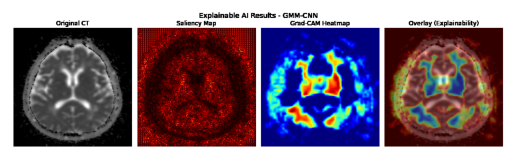

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import cv2

img_path = "Balanced_Brain_Stroke/hemorrhagic/58 (1).jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

def get_cnn_gradcam(model, img_array, layer_name=None, class_idx=1):
    if layer_name is None:
        # Pick last Conv2D layer if not provided
        conv_layers = [l.name for l in model.layers if "conv" in l.name]
        if not conv_layers:
            raise ValueError("No convolutional layer found in the model.")
        layer_name = conv_layers[-1]

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)+1e-8
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))
    return heatmap

# ================= GENERATE HEATMAP =================
heatmap = get_cnn_gradcam(cnn_model, img_array, class_idx=1)

# ================= PLOT =================
plt.figure(figsize=(16,4))
plt.suptitle("Explainable AI Results - GMM-CNN", fontsize=16, y=1.05)

# Original Image
plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original CT")
plt.axis('off')

# Saliency Map
plt.subplot(1,4,2)
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = cnn_model(img_array)
    loss = preds[:, 1]  # class index
grad = tape.gradient(loss, img_array)[0]
plt.imshow(np.max(grad, axis=-1), cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

# Grad-CAM Heatmap
plt.subplot(1,4,3)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Overlay Heatmap on Original Image
plt.subplot(1,4,4)
heatmap_rgb = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = 0.5 * np.array(img) + 0.5 * cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(overlay.astype(np.uint8))
plt.title("Overlay (Explainability)")
plt.axis('off')

plt.show()

# Precision-Recall Curve

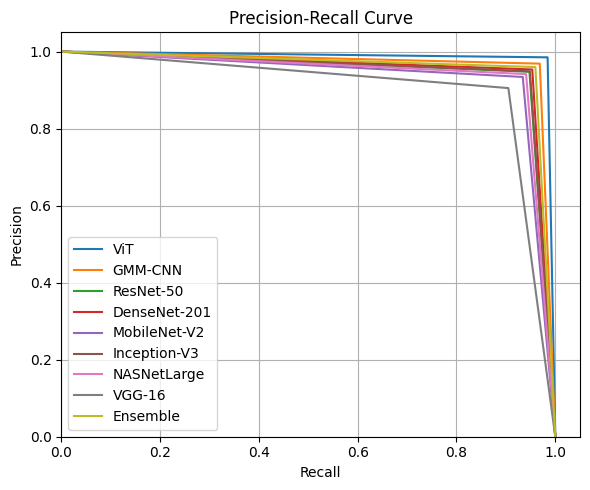

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = {
    "ViT": (0.9851, 0.9844),
    "GMM-CNN": (0.9687, 0.9686),
    "ResNet-50": (0.9475, 0.9477),
    "DenseNet-201": (0.9535, 0.9534),
    "MobileNet-V2": (0.9341, 0.9341),
    "Inception-V3": (0.9488, 0.9487),
    "NASNetLarge": (0.9415, 0.9409),
    "VGG-16": (0.9052, 0.9050),
    "Ensemble": (0.9598, 0.9597)
}

plt.figure(figsize=(6, 5))

for model, (precision, recall) in models.items():
    recall_curve = [0, recall, 1]
    precision_curve = [1, precision, 0]

    plt.plot(recall_curve, precision_curve, label=model)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()